# Работа с данными и моделями

In [3]:
import warnings
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor
from pandas import DataFrame, Series
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import pandas as pd
import numpy as np
import dill
import matplotlib.pyplot as plt

In [4]:

def warn(*args, **kwargs):
    pass


warnings.warn = warn

## Подготовка датасета

In [3]:
df = pd.read_csv('./kc_house_data.csv').drop(columns=['id'])

In [62]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [63]:
df['date'] = df.date.map(lambda x: int(x.split('T')[0]))

In [64]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,20141209,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [65]:
np.random.seed(42)
indeces_for_validation = np.random.permutation(len(df))[: int(len(df) * 0.3)]

df_test = df.loc[indeces_for_validation]
df_train = df.loc[list(set(np.arange(len(df))) - set(indeces_for_validation))]

In [66]:
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer([
    ('target_encode', TargetEncoder(target_type='continuous').set_output(
        transform='pandas'), ['zipcode'])
], remainder='passthrough', ).set_output(transform='pandas')


data_train = transformer.fit_transform(
    df_train, df_train['price']).rename(lambda x: x.split('__')[1], axis=1)
data_test = transformer.transform(df_test).rename(
    lambda x: x.split('__')[1], axis=1)

In [67]:
data_train.to_csv('./data_train_target.csv', index=False)
data_test.to_csv('./data_test_target.csv', index=False)

# Random-Forest

In [2]:
class RandomForestMSE:
    def __init__(
        self, n_estimators, *, max_depth=None, feature_subsample_size=None,
        splitter='best', bootstrap=None, random_state=42, **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.

        splitter: ['best', 'random']
            Criterion for splitting nodes in in trees

        bootstrap: None | int | float
            if None bootstraping is not performed. Otherwise defines splits for bootstraping

        random_state : int
            set the random state for estimators. 42 by default
        """
        self.trees = None

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.splitter = splitter
        self.random_state = random_state
        self.bootstrap = bootstrap

        # check if feature_subsample_size is in valid range of values
        if isinstance(feature_subsample_size, float) and \
                (feature_subsample_size > 1.0 or feature_subsample_size < 0.0):
            raise ValueError(
                'feature_subsample_size must be in range [0,1] or be integer')
        self.fss = feature_subsample_size if feature_subsample_size is not None else 1/3

        self.tree_parameters = trees_parameters

    def fit(self, X: np.ndarray, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects

        X_val : numpy ndarray
            Array of size n_val_objects, n_features

        y_val : numpy ndarray
            Array of size n_val_objects
        """
        self.trees = []

        # if X or y are not numpy datastructures than redefine them
        if isinstance(X, DataFrame):
            X = X.to_numpy()
        if isinstance(y, Series):
            y = y.to_numpy()

        # generator, used in trees random_state
        rnd_gen = np.random.Generator(np.random.PCG64(self.random_state))

        # check if predefined fss is less than count of features in objects
        if (isinstance(self.fss, int) and self.fss > X.shape[1]):
            raise ValueError(
                'X have less features than expected by feature_subsample_size')

        # if bootstrapping is enabled check and prepare splitting point
        bootstrap = None
        if self.bootstrap is not None:
            if (isinstance(self.bootstrap, int) and self.bootstrap > X.shape[0] or
                    isinstance(self.bootstrap, float) and (self.bootstrap > 1.0 or self.bootstrap < 0)):
                raise ValueError('bootstrap index out of range')
            else:
                bootstrap = self.bootstrap if isinstance(
                    self.bootstrap, int) else round(self.bootstrap * X.shape[0])

        history = None
        if X_val is not None and y_val is not None:
            history = {
                'rmse': {'train': [], 'test': []},
                'r2': {'train': [], 'test': []},
                'mape': {'train': [], 'test': []},
                'mae': {'train': [], 'test': []}
            }

        for _ in range(self.n_estimators):
            idx = np.random.permutation(
                X.shape[0])[:bootstrap] if bootstrap is not None else np.arange(X.shape[0])

            # define tree structure
            tree = DecisionTreeRegressor(
                criterion='squared_error',
                splitter=self.splitter,
                max_depth=self.max_depth,
                max_features=self.fss,
                random_state=rnd_gen.integers(0, 100_000_000),
                **self.tree_parameters
            )
            tree.fit(X[idx], y[idx])
            self.trees.append(tree)

            if history is not None:
                rmse, mae, r2, mape = self.make_metrics(X, y)
                history['rmse']['train'].append(rmse)
                history['mae']['train'].append(mae)
                history['r2']['train'].append(r2)
                history['mape']['train'].append(mape)

                rmse, mae, r2, mape = self.make_metrics(X_val, y_val)
                history['rmse']['test'].append(rmse)
                history['mae']['test'].append(mae)
                history['r2']['test'].append(r2)
                history['mape']['test'].append(mape)

        return self if history is None else history

    def make_metrics(self, X, y):
        preds = self.predict(X)

        rmse = mean_squared_error(y, preds, squared=False)
        mae = mean_absolute_error(y, preds)
        r2 = r2_score(y, preds)
        mape = mean_absolute_percentage_error(y, preds)

        return rmse, mae, r2, mape

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        # if model is not fitted yet raise error
        if self.trees is None:
            raise ValueError('model is not fited')
        preds = np.array([tree.predict(X) for tree in self.trees])

        return np.mean(preds, axis=0)

## Зависимость от параметра N - числа деревьев

In [69]:
data_train = pd.read_csv('./data_train_target.csv')
data_test = pd.read_csv('./data_test_target.csv')

In [70]:
X_train = data_train.drop(columns=['price'])
X_test = data_test.drop(columns=['price'])
y_train = data_train['price']
y_test = data_test['price']

In [ ]:
tree = RandomForestMSE(n_estimators=500)
history_rf_clear = tree.fit(X_train, y_train, X_test, y_test)

In [6]:
# dill.dump(history_rf_clear, open('./history_random_forest_clear_settings.db', 'wb'))
# history_rf_clear = dill.load(open('./history_random_forest_clear_settings.db', 'rb'))

In [9]:
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

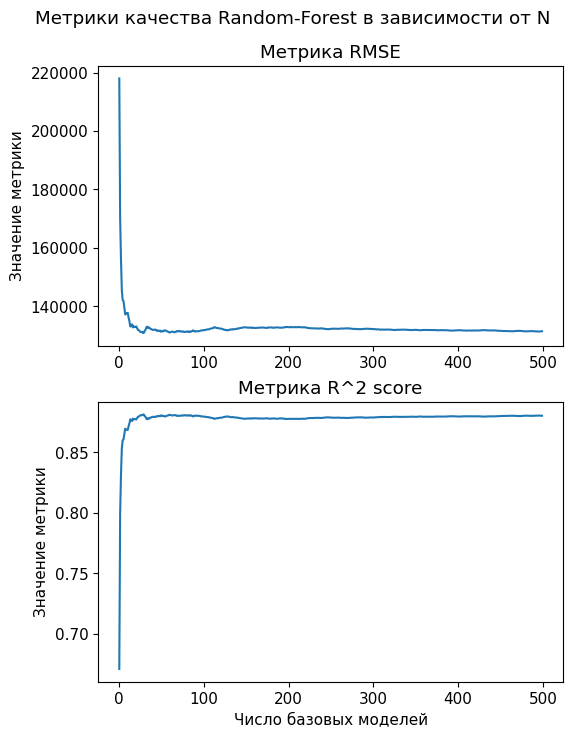

In [10]:
fig, axis = plt.subplots(2, 1)
fig.set_figwidth(6)
fig.set_figheight(8)
title = fig.suptitle('Метрики качества Random-Forest в зависимости от N')
axis[1].set_xlabel('Число базовых моделей')
axis[0].set_ylabel('Значение метрики')
axis[0].set_title('Метрика RMSE')
axis[0].plot(np.arange(len(history_rf_clear['rmse']['test'])),
             history_rf_clear['rmse']['test'])
# axis[0].plot(np.arange(len(history_rf_clear['rmse']['train'])), history_rf_clear['rmse']['train'])
axis[1].set_ylabel('Значение метрики')
axis[1].set_title('Метрика R^2 score')
axis[1].plot(np.arange(len(history_rf_clear['r2']['test'])),
             history_rf_clear['r2']['test'])
# axis[1].plot(np.arange(len(history_rf_clear['r2']['train'])), history_rf_clear['r2']['train'])

title.set_position((0.45, 0.95))
plt.savefig('./figures/random-forest-clear.eps',
            format='eps', bbox_inches='tight')

In [11]:
print('RMSE: ', history_rf_clear['rmse']['test'][-1])
print('R2 score: ', history_rf_clear['r2']['test'][-1])

RMSE:  131444.14480861367
R2 score:  0.8803376464007283


In [14]:
tree = RandomForestMSE(n_estimators=500, bootstrap=0.4)
history_rf_bootstrap = tree.fit(X_train, y_train, X_test, y_test)

In [15]:
dill.dump(history_rf_bootstrap, open(
    './history_random_forest_bootstrap.db', 'wb'))
# history_rf_bootstrap = dill.load(open('./history_random_forest_bootstrap.db', 'rb'))

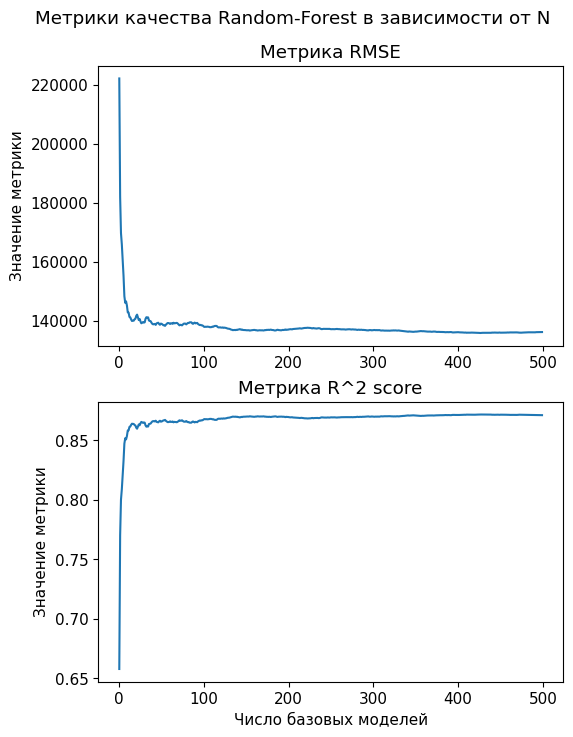

In [16]:
fig, axis = plt.subplots(2, 1)
fig.set_figwidth(6)
fig.set_figheight(8)
title = fig.suptitle('Метрики качества Random-Forest в зависимости от N')
axis[1].set_xlabel('Число базовых моделей')
axis[0].set_ylabel('Значение метрики')
axis[0].set_title('Метрика RMSE')
axis[0].plot(np.arange(len(history_rf_bootstrap['rmse']['test'])),
             history_rf_bootstrap['rmse']['test'])
# axis[0].plot(np.arange(len(history_rf_clear['rmse']['train'])), history_rf_clear['rmse']['train'])
axis[1].set_ylabel('Значение метрики')
axis[1].set_title('Метрика R^2 score')
axis[1].plot(np.arange(len(history_rf_bootstrap['r2']['test'])),
             history_rf_bootstrap['r2']['test'])
# axis[1].plot(np.arange(len(history_rf_clear['r2']['train'])), history_rf_clear['r2']['train'])

title.set_position((0.45, 0.95))
plt.savefig('./figures/random-forest-bootstrap.eps',
            format='eps', bbox_inches='tight')

In [18]:
print('RMSE: ', history_rf_bootstrap['rmse']['test'][-1])
print('R2 score: ', history_rf_bootstrap['r2']['test'][-1])

RMSE:  136326.41960004155
R2 score:  0.8712832374984882


## Варьировние параметра n_features

In [41]:
n_fet_variation_rf = {}
for i in [1, 2, 6, 7, 10, 15, 17, 19]:
    tree = RandomForestMSE(n_estimators=150, feature_subsample_size=i)
    n_fet_variation_rf[i] = tree.fit(X_train, y_train, X_test, y_test)

In [50]:
dill.dump(n_fet_variation_rf, open(
    './history_random_forest_nfeat_setting.db', 'wb'))
# n_fet_variation_rf = dill.load(open('./history_random_forest_nfeat_setting.db', 'rb'))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


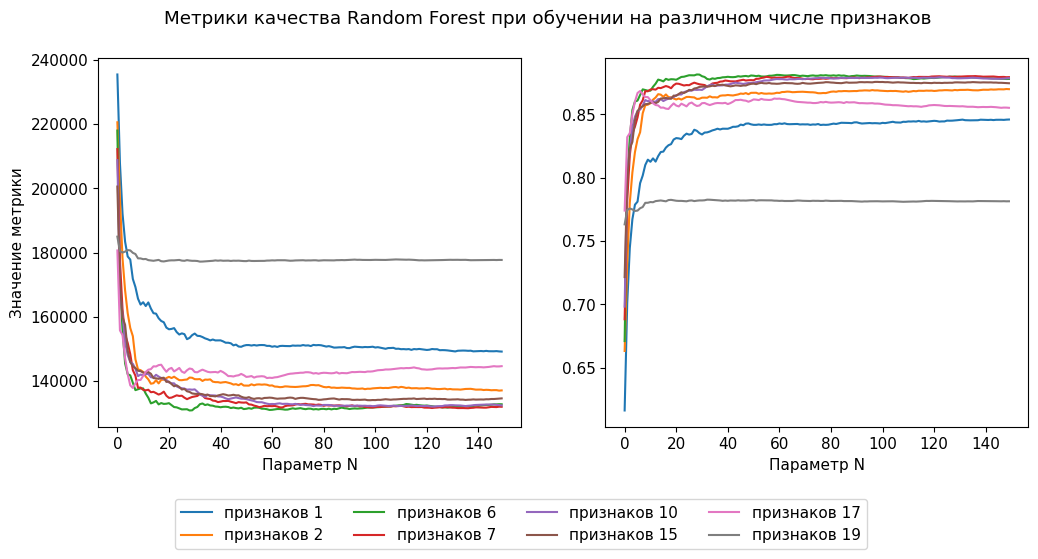

In [53]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.suptitle(
    'Метрики качества Random Forest при обучении на различном числе признаков')
axis[0].set_ylabel('Значение метрики')
axis[0].set_xlabel('Параметр N')
axis[1].set_xlabel('Параметр N')
for i, hist in n_fet_variation_rf.items():
    axis[0].plot(np.arange(150), hist['rmse']['test'], label=f'признаков {i}')
    axis[1].plot(np.arange(150), hist['r2']['test'], label=f'признаков {i}')

plt.legend(loc='lower center', ncol=4, bbox_to_anchor=(-0.2, -0.35))
plt.savefig('./figures/random-forest-features-settings.eps',
            format='eps', bbox_inches='tight')

## Оценка влияния max_depth

In [ ]:
depth_rf_history = {}
for d in [3, 5, 7, 10, 15, 20, 25, 30, None]:
    tree = RandomForestMSE(150, max_depth=d)
    depth_rf_history[d] = tree.fit(X_train, y_train, X_test, y_test)
ends_rmse = [hist['rmse']['test'][-1]
             for ind, hist in depth_rf_history.items()]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


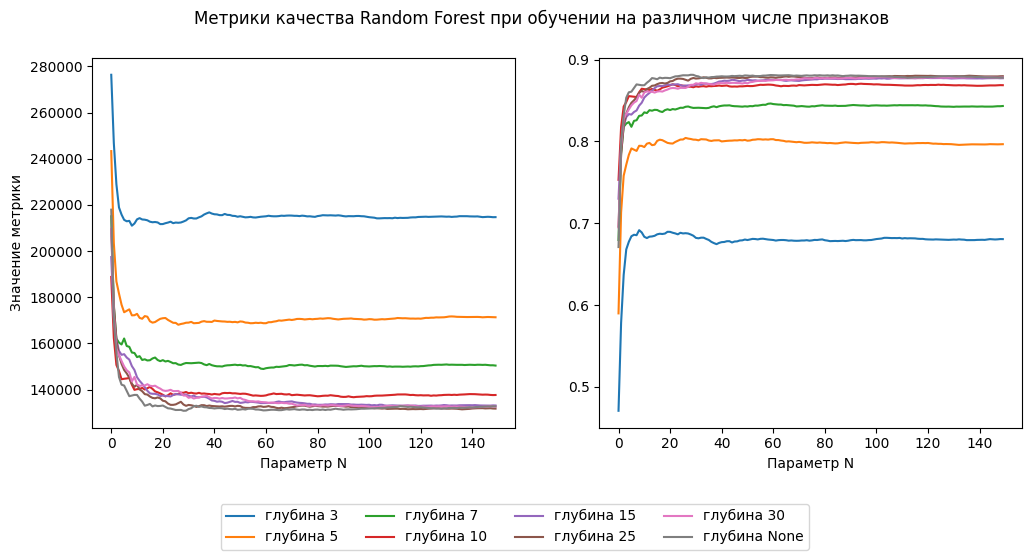

In [ ]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.suptitle(
    'Метрики качества Random Forest при обучении на различном числе признаков')
axis[0].set_ylabel('Значение метрики')
axis[0].set_xlabel('Параметр N')
axis[1].set_xlabel('Параметр N')
for i, hist in depth_rf_history.items():
    axis[0].plot(np.arange(150), hist['rmse']['test'], label=f'глубина {i}')
    axis[1].plot(np.arange(150), hist['r2']['test'], label=f'глубина {i}')

plt.legend(loc='lower center', ncol=4, bbox_to_anchor=(-0.2, -0.35))
plt.savefig('./figures/random-forest-features-settings.eps',
            format='eps', bbox_inches='tight')

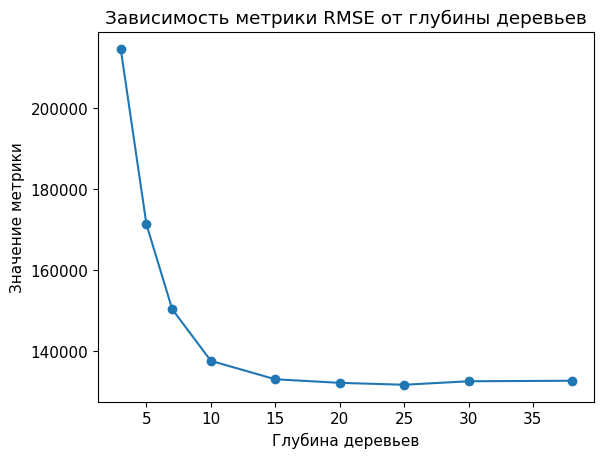

In [ ]:
import matplotlib.ticker as ticker
plt.title('Зависимость метрики RMSE от глубины деревьев')
plt.scatter([3, 5, 7, 10, 15, 20, 25, 30, 38, ], t)
plt.plot([3, 5, 7, 10, 15, 20, 25, 30, 38], t)
plt.ylabel('Значение метрики')
plt.xlabel('Глубина деревьев')
plt.savefig('./figures/random-forest-depth_fet.eps',
            format='eps', bbox_inches='tight')

# Gradient Boosting

In [5]:
class GradientBoostingMSE:
    def __init__(
        self, n_estimators, *, learning_rate=0.1, max_depth=5,
        splitter='best', feature_subsample_size=None, random_state=42,
        bootstrap=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        learning_rate : float
            Use alpha * learning_rate instead of alpha

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float | None
            The size of feature set for each tree. If None then use one-third of all features.


        splitter: ['best', 'random']
            Criterion for splitting nodes in in trees


        splitter: ['best', 'random']
            Criterion for splitting nodes in in trees

        bootstrap: None | int | float
            if None bootstraping is not performed. Otherwise defines splits for bootstraping

        random_state : int
            set the random state for estimators. 42 by default
        """
        self.weights = None
        self.trees = None

        self.n_estimators = n_estimators
        self.lr = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.splitter = splitter
        self.bootstrap = bootstrap

        # check if feature_subsample_size is in valid range of values
        if isinstance(feature_subsample_size, float) and \
                (feature_subsample_size > 1.0 or feature_subsample_size < 0.0):
            raise ValueError(
                'feature_subsample_size must be in range [0,1] or be integer')
        self.fss = feature_subsample_size if feature_subsample_size is not None else 1/3
        self.trees_parameters = trees_parameters

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects
        """
        self.weights = []
        self.trees = []

        # if X or y are not numpy datastructures than redefine them
        if isinstance(X, DataFrame):
            X = X.to_numpy()
        if isinstance(y, Series):
            y = y.to_numpy()

        # generator, used in trees random_state
        rnd_gen = np.random.Generator(np.random.PCG64(self.random_state))

        # check if predefined fss is less than count of features in objects
        if (isinstance(self.fss, int) and self.fss > X.shape[1]):
            raise ValueError(
                'X have less features than expected by feature_subsample_size')

        # if bootstrapping is enabled check and prepare splitting point
        bootstrap = None
        if self.bootstrap is not None:
            if (isinstance(self.bootstrap, int) and self.bootstrap > X.shape[0] or
                    isinstance(self.bootstrap, float) and (self.bootstrap > 1.0 or self.bootstrap < 0)):
                raise ValueError('bootstrap index out of range')
            else:
                bootstrap = self.bootstrap if isinstance(
                    self.bootstrap, int) else round(self.bootstrap * X.shape[0])

        history = None
        if X_val is not None and y_val is not None:
            history = {
                'rmse': {'train': [], 'test': []},
                'r2': {'train': [], 'test': []},
                'mape': {'train': [], 'test': []},
                'mae': {'train': [], 'test': []}
            }

        # initialize first target for boosting
        grad = y.copy()
        for _ in range(self.n_estimators):
            idx = np.random.permutation(
                X.shape[0])[:bootstrap] if bootstrap is not None else np.arange(X.shape[0])

            tree = DecisionTreeRegressor(
                criterion='squared_error',
                splitter=self.splitter,
                max_features=self.fss,
                random_state=rnd_gen.integers(0, 100_000_000),
                max_depth=self.max_depth,
                **self.trees_parameters
            )
            tree = tree.fit(X[idx], grad[idx])
            preds = tree.predict(X)
            alpha = minimize_scalar(fun=lambda a: np.sum(
                (grad - a * preds) ** 2), bounds=(0, 10000)).x

            grad -= self.lr * alpha * preds
            self.trees.append(tree)
            self.weights.append(self.lr * alpha)

            if history is not None:
                rmse, mae, r2, mape = self.make_metrics(X, y)
                history['rmse']['train'].append(rmse)
                history['mae']['train'].append(mae)
                history['r2']['train'].append(r2)
                history['mape']['train'].append(mape)

                rmse, mae, r2, mape = self.make_metrics(X_val, y_val)
                history['rmse']['test'].append(rmse)
                history['mae']['test'].append(mae)
                history['r2']['test'].append(r2)
                history['mape']['test'].append(mape)

        return self if history is None else history

    def make_metrics(self, X, y):
        preds = self.predict(X)

        rmse = mean_squared_error(y, preds, squared=False)
        mae = mean_absolute_error(y, preds)
        r2 = r2_score(y, preds)
        mape = mean_absolute_percentage_error(y, preds)

        return rmse, mae, r2, mape

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        # if model is not fitted yet raise error
        if self.trees is None or self.weights is None:
            raise ValueError('model is not fited')
        preds = np.array([w * tree.predict(X)
                         for w, tree in zip(self.weights, self.trees)])
        return np.sum(preds, axis=0)

In [229]:
# grad_boosting_history_oversee = []
for n in [10, 30, 50, 100, 150, 200]:
    for d in [5, 10, 15, 25, 50, 100, None]:
        for f in [3, 6, 8, 12]:
            for lr in [0.01, 0.1, 0.5]:
                tree = GradientBoostingMSE(
                    n_estimators=n, max_depth=d, feature_subsample_size=f, learning_rate=lr)
                grad_boosting_history_oversee.append({
                    'n_estimators': n,
                    'max_depth': d,
                    'feature_subsample_size': f,
                    'learning_rate': lr,
                    'history': tree.fit(X_train, y_train, X_test, y_test)
                })

dill.dump(grad_boosting_history_oversee, open(
    './history_grad_boost_oversee.db', 'wb'))

In [48]:
grad_boosting_history_oversee = dill.load(
    open('./history_grad_boost_oversee.db', 'rb'))

In [49]:
gb_hist_df = pd.DataFrame(grad_boosting_history_oversee)
gb_hist_df['rmse_final'] = gb_hist_df.history.apply(
    lambda x: x['rmse']['test'][-1])
gb_hist_df['r2_final'] = gb_hist_df.history.apply(
    lambda x: x['r2']['test'][-1])
gb_hist_df['rmse_test'] = gb_hist_df.history.apply(
    lambda x: np.array(x['rmse']['test']))

In [309]:
gb_hist_df.head(10)

,n_estimators,max_depth,feature_subsample_size,learning_rate,history,rmse_final,r2_final,rmse_test
0,10,5.0,3,0.01,"{'rmse': {'train': [642063.8732379917, 636265....",609247.973928,-1.570770,"[659329.4234640388, 653588.180318022, 647772.7..."
1,10,5.0,3,0.10,"{'rmse': {'train': [590465.0448896931, 538299....",293437.665116,0.403642,"[608164.7296105942, 556614.0119349576, 509011...."
2,10,5.0,3,0.50,"{'rmse': {'train': [373196.9606518344, 246553....",169521.928257,0.800966,"[396466.7353854277, 276697.1073244126, 221200...."
3,10,5.0,6,0.01,"{'rmse': {'train': [642034.2619028114, 636159....",608012.188199,-1.560352,"[659341.3163162392, 653535.5537764371, 647599...."
4,10,5.0,6,0.10,"{'rmse': {'train': [590157.5445205114, 536921....",285934.876165,0.433749,"[608240.2706758077, 555699.5204588963, 507519...."
5,10,5.0,6,0.50,"{'rmse': {'train': [371272.0180390835, 230757....",144388.315460,0.855609,"[395224.27215473354, 253481.84378689763, 18919..."
6,10,5.0,8,0.01,"{'rmse': {'train': [641855.272805127, 635930.8...",607704.533469,-1.557761,"[659083.234797624, 653173.6198704322, 647270.6..."
7,10,5.0,8,0.10,"{'rmse': {'train': [588295.7043167383, 534764....",284731.981417,0.438503,"[605568.9478244402, 552293.2690650006, 504181...."
8,10,5.0,8,0.50,"{'rmse': {'train': [359419.008036877, 222066.1...",142173.282769,0.860005,"[378877.78067924746, 243773.7563776229, 184504..."
9,10,5.0,12,0.01,"{'rmse': {'train': [641827.3858759055, 635868....",607467.704571,-1.555768,"[658988.0454310206, 653005.4789079083, 646964...."


## Оценка качества в зависимости от глубины деревьев

In [323]:
working_set = gb_hist_df[(gb_hist_df['learning_rate'] == 0.1)].groupby(
    ['max_depth', 'n_estimators'])
rmse_avg = working_set.mean('rmse_final')

In [324]:
from collections import defaultdict
lines = defaultdict(lambda: {})
for d, n in rmse_avg.rmse_final.index:
    lines[d][n] = rmse_avg.rmse_final[(d, n)]

In [8]:
setter = {}
for d in [5, 10, 15, 25, 50, 100]:
    l = []
    gb_hist_df[(gb_hist_df['max_depth'] == d) & (
        gb_hist_df['n_estimators'] == 200) & (gb_hist_df['learning_rate'] == 0.1)].rmse_test.apply(lambda x: l.append(x))
    setter[d] = np.array(l).mean(axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


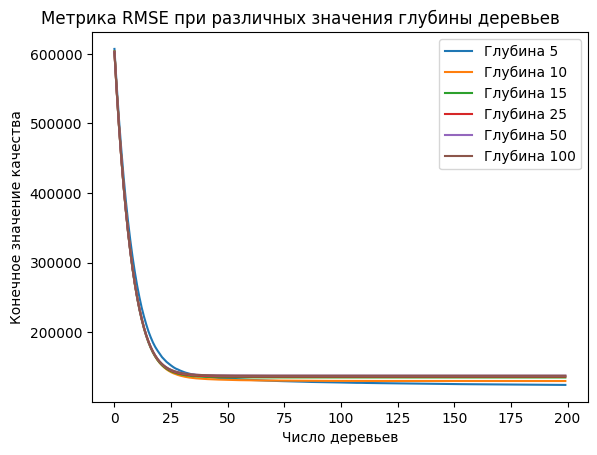

In [9]:
title = plt.title('Метрика RMSE при различных значения глубины деревьев')
for d, l in setter.items():
    plt.plot(np.arange(len(l)), l, label=f'Глубина {int(d)}')
plt.xlabel('Число деревьев')
plt.ylabel('Конечное значение качества')
plt.legend()
plt.savefig('./figures/grad_boost_hist_depth.eps',
            format='eps', bbox_inches='tight')
title.set_position((0.42, 0))

## Оценка качества в зависимости от числа деревьев

In [307]:
gb_hist_df.head(6)

,n_estimators,max_depth,feature_subsample_size,learning_rate,history,rmse_final,r2_final,rmse_test
0,10,5.0,3,0.01,"{'rmse': {'train': [642063.8732379917, 636265....",609247.973928,-1.570770,"[659329.4234640388, 653588.180318022, 647772.7..."
1,10,5.0,3,0.10,"{'rmse': {'train': [590465.0448896931, 538299....",293437.665116,0.403642,"[608164.7296105942, 556614.0119349576, 509011...."
2,10,5.0,3,0.50,"{'rmse': {'train': [373196.9606518344, 246553....",169521.928257,0.800966,"[396466.7353854277, 276697.1073244126, 221200...."
3,10,5.0,6,0.01,"{'rmse': {'train': [642034.2619028114, 636159....",608012.188199,-1.560352,"[659341.3163162392, 653535.5537764371, 647599...."
4,10,5.0,6,0.10,"{'rmse': {'train': [590157.5445205114, 536921....",285934.876165,0.433749,"[608240.2706758077, 555699.5204588963, 507519...."
5,10,5.0,6,0.50,"{'rmse': {'train': [371272.0180390835, 230757....",144388.315460,0.855609,"[395224.27215473354, 253481.84378689763, 18919..."


In [304]:
working_set = gb_hist_df[(gb_hist_df['max_depth'] == 5.0) | (gb_hist_df['max_depth'] == 10.0)].groupby(
    ['learning_rate'])
rmse_avg = working_set.mean('rmse_final')

In [38]:
setter = {}
for lr in [0.01, 0.1, 0.5]:
    l = []
    gb_hist_df[(gb_hist_df['learning_rate'] == lr) & (
        gb_hist_df['n_estimators'] == 200)].rmse_test.apply(lambda x: l.append(x))
    setter[lr] = np.array(l).mean(axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


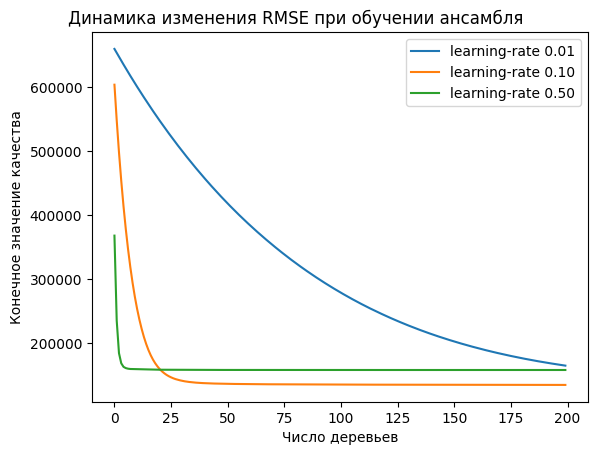

In [39]:
title = plt.title('Динамика изменения RMSE при обучении ансамбля')
for lr, l in setter.items():
    # plt.scatter(l.keys(), l.values(), label=f'learning-rate {lr:0.2f}')
    plt.plot(np.arange(l.shape[0]), l, label=f'learning-rate {lr:0.2f}')
plt.xlabel('Число деревьев')
plt.ylabel('Конечное значение качества')
plt.legend()
title.set_position((0.41, 0))
plt.savefig('./figures/grad_boost_hist_n_estimators.eps',
            format='eps', bbox_inches='tight')

In [ ]:
gb_hist_df.learning_rate.unique()

In [52]:
setter = {}
for lr in [1.8, 2.2, 2.5, 3, 4, 5]:
    l = []
    gb_hist_df[(gb_hist_df['learning_rate'] == lr) & (
        gb_hist_df['n_estimators'] == 200)].rmse_test.apply(lambda x: l.append(x))
    setter[lr] = np.array(l).mean(axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


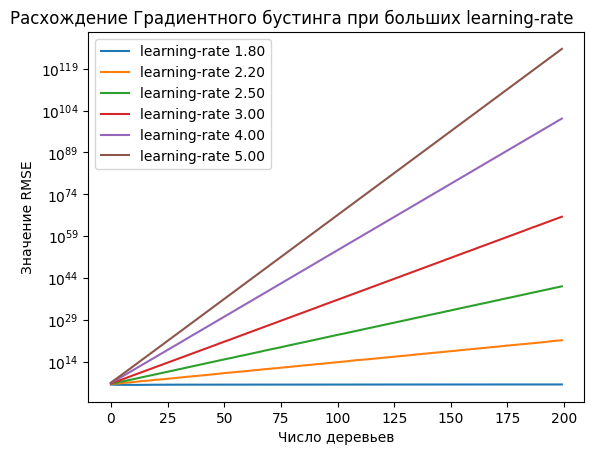

In [54]:
title = plt.title(
    'Расхождение Градиентного бустинга при больших learning-rate')
for lr, l in setter.items():
    # plt.scatter(l.keys(), l.values(), label=f'learning-rate {lr:0.2f}')
    plt.plot(np.arange(l.shape[0]), l, label=f'learning-rate {lr:0.2f}')
plt.xlabel('Число деревьев')
plt.ylabel('Значение RMSE')
plt.legend()
title.set_position((0.41, 0))
plt.yscale('log')
plt.savefig('./figures/grad_boost_hist_bad_lr.eps',
            format='eps', bbox_inches='tight')

## Величина подвыборки признаков

In [65]:
gb_hist_df

,n_estimators,max_depth,feature_subsample_size,learning_rate,history,rmse_final,r2_final,rmse_test
0,10,5.0,3.000000,0.01,"{'rmse': {'train': [642063.8732379917, 636265....",6.092480e+05,-1.570770e+00,"[659329.4234640388, 653588.180318022, 647772.7..."
1,10,5.0,3.000000,0.10,"{'rmse': {'train': [590465.0448896931, 538299....",2.934377e+05,4.036424e-01,"[608164.7296105942, 556614.0119349576, 509011...."
2,10,5.0,3.000000,0.50,"{'rmse': {'train': [373196.9606518344, 246553....",1.695219e+05,8.009662e-01,"[396466.7353854277, 276697.1073244126, 221200...."
3,10,5.0,6.000000,0.01,"{'rmse': {'train': [642034.2619028114, 636159....",6.080122e+05,-1.560352e+00,"[659341.3163162392, 653535.5537764371, 647599...."
4,10,5.0,6.000000,0.10,"{'rmse': {'train': [590157.5445205114, 536921....",2.859349e+05,4.337486e-01,"[608240.2706758077, 555699.5204588963, 507519...."
...,...,...,...,...,...,...,...,...
676,200,5.0,0.333333,1.80,"{'rmse': {'train': [533293.0154819806, 447359....",5.801655e+05,-1.331197e+00,"[545341.724192836, 522548.91173705494, 447928...."
677,200,5.0,0.333333,3.00,"{'rmse': {'train': [1243808.4805209574, 241040...",8.898714e+65,-5.484406e+120,"[1249972.8271915389, 2604159.3974017645, 48184..."
678,200,5.0,0.333333,2.00,"{'rmse': {'train': [647831.9506988057, 647831....",1.733003e+06,-1.980050e+01,"[657715.7359383699, 765017.0389285167, 691350...."
679,200,5.0,0.333333,4.00,"{'rmse': {'train': [1850949.765930609, 5393255...",1.478144e+101,-1.513243e+191,"[1857078.6208988093, 5711383.912109203, 158393..."


In [66]:
setter = {}
for f in [3, 6, 8, 12, 1/3]:
    l = []
    gb_hist_df[(gb_hist_df['feature_subsample_size'] == f) & (gb_hist_df.max_depth == 5.0) &
               (gb_hist_df['n_estimators'] == 200) & (gb_hist_df['learning_rate'] < 1)].rmse_test.apply(lambda x: l.append(x))
    setter[f] = np.array(l).mean(axis=0)

/Users/artemon/.local/share/virtualenvs/Ensembles-ML-TS4PNHrl/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: tuple index out of range

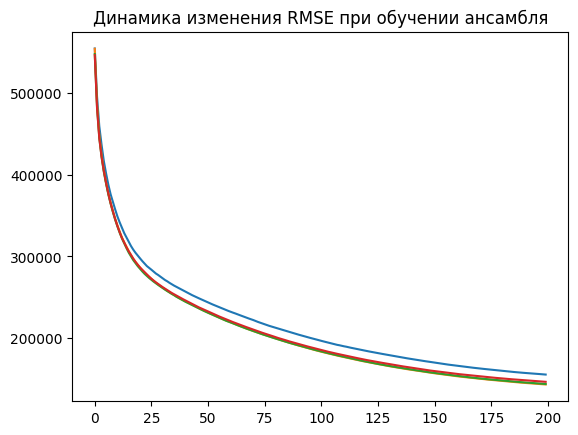

In [67]:
title = plt.title('Динамика изменения RMSE при обучении ансамбля')
for f, l in setter.items():
    # plt.scatter(l.keys(), l.values(), label=f'learning-rate {lr:0.2f}')
    plt.plot(np.arange(l.shape[0]), l, label=f'число признаков {lr:0.2f}')
plt.xlabel('Число деревьев')
plt.ylabel('Конечное значение качества')
plt.legend()
title.set_position((0.41, 0))
plt.savefig('./figures/grad_boost_hist_n_estimators.eps',
            format='eps', bbox_inches='tight')

In [68]:
gb_hist_df[(gb_hist_df['learning_rate'] == 0.1) & (
    gb_hist_df['n_estimators'] == 200) & (gb_hist_df['max_depth'] == 5.0)]

,n_estimators,max_depth,feature_subsample_size,learning_rate,history,rmse_final,r2_final,rmse_test
421,200,5.0,3.0,0.1,"{'rmse': {'train': [590465.0448896931, 538299....",126606.097863,0.888984,"[608164.7296105942, 556614.0119349576, 509011...."
424,200,5.0,6.0,0.1,"{'rmse': {'train': [590157.5445205114, 536921....",123107.511821,0.895035,"[608240.2706758077, 555699.5204588963, 507519...."
427,200,5.0,8.0,0.1,"{'rmse': {'train': [588295.7043167383, 534764....",122239.665031,0.896510,"[605568.9478244402, 552293.2690650006, 504181...."
430,200,5.0,12.0,0.1,"{'rmse': {'train': [588005.1412008241, 533949....",125283.106543,0.891292,"[604656.2969495219, 550877.2629259834, 501701...."


In [72]:
points = {}
for sub in [1, 3, 5, 6, 9, 12, 15, 19]:
    gb = GradientBoostingMSE(
        n_estimators=100, max_depth=5, feature_subsample_size=sub)
    points[sub] = gb.fit(X_train, y_train, X_test, y_test)

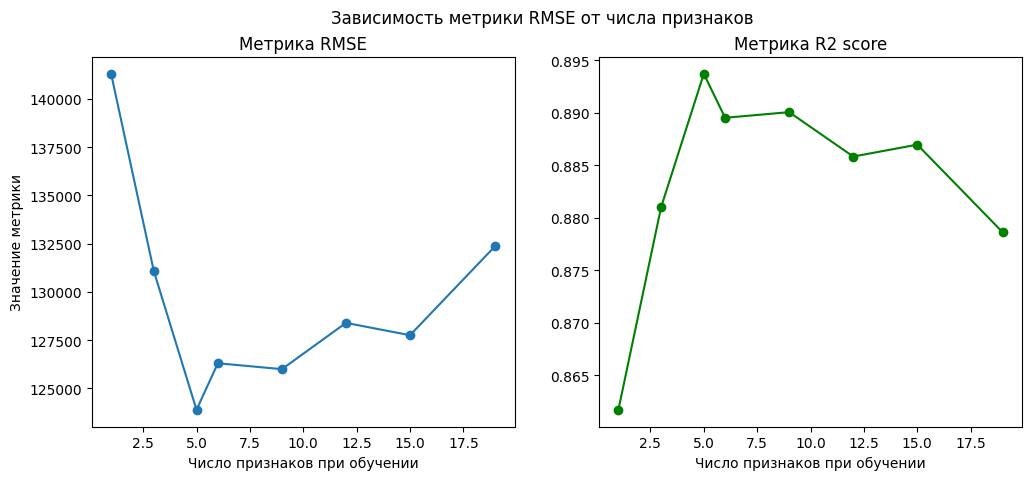

In [85]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(12)


fig.suptitle('Зависимость метрики RMSE от числа признаков')
axis[0].scatter([int(x) for x in points.keys()], [x['rmse']['test'][-1]
                                                  for x in points.values()])
axis[0].plot([int(x) for x in points.keys()],  [x['rmse']['test'][-1]
                                                for x in points.values()])
axis[0].set_ylabel('Значение метрики')
axis[0].set_xlabel('Число признаков при обучении')
axis[0].set_title('Метрика RMSE')

axis[1].scatter([int(x) for x in points.keys()], [x['r2']['test'][-1]
                                                  for x in points.values()], c='g')
axis[1].plot([int(x) for x in points.keys()],  [x['r2']['test'][-1]
                                                for x in points.values()], c='g')
axis[1].set_title('Метрика R2 score')
axis[1].set_xlabel('Число признаков при обучении')

plt.savefig('./figures/grad_boost_hist_fet_sub.eps',
            format='eps', bbox_inches='tight')